In [1]:
from train.models.bisenetv1 import BiSeNet
import torch

import os
import os.path as osp
import argparse
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import PIL

In [2]:
def vis_parsing_maps(
        im: Image,
        parsing_anno: np.ndarray,
        stride: int,
        save_path: str,
        save_im: bool = False
        ) -> None:
    """
    Visualizes parsing annotations on an image using color mapping and optional saving.

    Args:
        im : The input image.
        parsing_anno : Parsing annotation array containing class labels.
        stride : Scaling factor for resizing the parsing annotation.
        save_path : Path to save the visualization image.
        save_im : Whether to save the visualization image. Default is False.

    Returns:
        None

    This function visualizes parsing annotations on an input image by assigning colors to different
    parts based on provided class labels. The visualization can be optionally saved to a file.
    The parsed image can be displayed or saved depending on the 'save_im' parameter.
    """
    # Colors for all 20 parts
    part_colors = [
        [20, 20, 20], [0, 0, 255], [50, 65, 225],
        [0, 140, 255], [0, 252, 124],
        [167, 108, 188], [66, 71, 147], [170, 255, 0],
        [19, 69, 139], [0, 255, 170],
        [0, 0, 255], [85, 219, 236], [170, 0, 255],
        [0, 85, 255], [0, 170, 255],
        [255, 255, 0], [255, 255, 85], [255, 255, 170],
        [255, 0, 255], [255, 85, 255], [255, 170, 255],
        [0, 255, 255], [85, 255, 255], [170, 255, 255]
    ]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(
        vis_parsing_anno, None, fx=stride, fy=stride,
        interpolation=cv2.INTER_NEAREST
    )
    vis_parsing_anno_color = np.zeros(
        (vis_parsing_anno.shape[0],
         vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = 2

    for pi in range(0, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    vis_im = cv2.addWeighted(
        cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR),
        0.75,
        vis_parsing_anno_color,
        0.5,
        0
    )
    print('Parsing anno shape:', vis_parsing_anno.shape)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] + '.png', vis_parsing_anno*200)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

In [3]:
def create_hair_mask(seg_mask, hair_label):
  hair_present = False
  for i in np.unique(seg_mask):
      image_array_test = seg_mask.copy()  
      image_array_test_mono = np.where(image_array_test == i,1,0)
      if abs(i - hair_label) < 0.001:
          hair_mask = image_array_test_mono.copy()
          hair_present = True
        #   print('Hair Detected')
          return hair_mask
      

def get_crop_coords(final_combined_hair_mask):

  # Find contours
  final_combined_hair_mask = final_combined_hair_mask.astype(np.uint8)
  contours, _ = cv2.findContours(final_combined_hair_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find largest contour
  largest_contour = max(contours, key=cv2.contourArea)

  # Calculate centroid
  M = cv2.moments(largest_contour)
  if M["m00"] != 0:
      cx = int(M["m10"] / M["m00"])  
      cy = int(M["m01"] / M["m00"])
  else:
      cx, cy = 0, 0

  crop_size = 512

  # Calculate crop coordinates
  x1 = max(0, cx - crop_size//2)
  x2 = min(final_combined_hair_mask.shape[1], cx + crop_size//2)
  y1 = max(0, cy - crop_size//2) 
  y2 = min(final_combined_hair_mask.shape[0], cy + crop_size//2)

  return x1, x2, y1, y2

def get_patches_inference(cropped_img, cropped_mask, threshold=1):

    resized_cropped_mask = cv2.resize(cropped_mask, (512, 512), interpolation = cv2.INTER_NEAREST)
    # resized_cropped_mask_for_filtering = cv2.resize(cropped_mask_for_filtering, (512, 512), interpolation = cv2.INTER_NEAREST)
    resized_cropped_img = cv2.resize(cropped_img, (512, 512), interpolation = cv2.INTER_NEAREST)
    ##############################################################################
    print('In get_patches_inference')
    plt.imshow(cropped_img)
    plt.show()
    plt.imshow(resized_cropped_img)
    plt.show()
    ##############################################################################
    # Get image dimensions
    height, width = resized_cropped_mask.shape

    # Set number of patches
    num_patches = 64

    # Calculate patch size  
    patch_size = int(width / np.sqrt(num_patches))

    # Initialize empty lists
    patches = [] 
    filtered_patches = []
    patch_map_linear = []
    img_patches = []

    idx = 0
    # Loop over image and extract patches  
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):

            patch = resized_cropped_mask[i:i+patch_size, j:j+patch_size]
            # patch_inspect = resized_cropped_mask_for_filtering[i:i+patch_size, j:j+patch_size]
            patch_inspect = patch
            img_patch = resized_cropped_img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            img_patches.append(img_patch)

            unique = np.unique(patch_inspect)

            if len(unique)>1 and 1 in unique:
                num_matches = (patch_inspect==1).sum()
                fraction = num_matches / patch.size
                
                if 0.3< fraction < threshold: 
                    filtered_patches.append(patch)  
                    patch_map_linear.append(idx)

            idx += 1

    return img_patches, patches, filtered_patches, patch_map_linear


def combine_patches(patches, generated_patches, patches_per_row, total_patches, patch_map_linear):
    # Calculate the number of rows
    
    num_rows = total_patches // patches_per_row
    
    # Get the dimensions of the first patch
    patch_height, patch_width = patches[0].shape
    
    # Create a new array with the combined dimensions
    combined_width = patch_width * patches_per_row
    combined_height = patch_height * num_rows
    combined_mask = np.zeros((combined_height, combined_width), dtype=patches[0].dtype)

    gen_patch_index = 0

    for idx, patch in enumerate(patches):
        row = idx // patches_per_row
        col = idx % patches_per_row
        x = col * patch_width
        y = row * patch_height
        # print(len(patch_map_linear))
        if gen_patch_index < len(patch_map_linear) and idx == patch_map_linear[gen_patch_index]:
            combined_mask[y:y+patch_height, x:x+patch_width] = generated_patches[gen_patch_index]
            gen_patch_index += 1
        
        else:
            combined_mask[y:y+patch_height, x:x+patch_width] = patch
    
    return combined_mask

def combine_patches_color(patches, generated_patches, patches_per_row, total_patches, patch_map_linear):
    # Calculate the number of rows
    
    num_rows = total_patches // patches_per_row
    print(patches[0].shape)
    # Get the dimensions of the first patch
    patch_height, patch_width, _ = patches[0].shape
    
    # Create a new array with the combined dimensions
    combined_width = patch_width * patches_per_row
    combined_height = patch_height * num_rows
    combined_mask = np.zeros((combined_height, combined_width, 3), dtype=patches[0].dtype)

    gen_patch_index = 0

    for idx, patch in enumerate(patches):
        row = idx // patches_per_row
        col = idx % patches_per_row
        x = col * patch_width
        y = row * patch_height
        # print(len(patch_map_linear))
        if gen_patch_index < len(patch_map_linear) and idx == patch_map_linear[gen_patch_index]:
            combined_mask[y:y+patch_height, x:x+patch_width, :] = generated_patches[gen_patch_index]
            gen_patch_index += 1
        
        else:
            combined_mask[y:y+patch_height, x:x+patch_width, :] = patch
    
    return combined_mask

In [4]:

def evaluate(img_dir, mask_dir, output_dir, checkpoint_pth):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        os.makedirs(output_dir + '/output_images')
        os.makedirs(output_dir + '/output_masks')


    n_classes = 2
    net = BiSeNet(n_classes=n_classes, mode='infer')
    net.cuda(0)
    net.load_state_dict(torch.load(checkpoint_pth))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        ])
    

    img_file_names = sorted([f for f in os.listdir(img_dir)])
    # alpha_file_names = sorted([f for f in os.listdir(mask_dir)])
    alpha_file_names = [i[:-4]+'_mask.png' for i in img_file_names]

    img_file_paths = [os.path.join(img_dir, file_name) for file_name in img_file_names]
    mask_file_paths = [os.path.join(mask_dir, file_name) for file_name in alpha_file_names]
    combined_images = []
    with torch.no_grad():
        
        for idx in range(6,len(img_file_paths)):
            img = mpimg.imread(img_file_paths[idx])
            mask = cv2.imread(mask_file_paths[idx], cv2.IMREAD_GRAYSCALE)
            print(np.unique(mask))
            resized_img = cv2.resize(
                img.astype(np.uint8),
                mask.shape[::-1],
                interpolation=cv2.INTER_CUBIC
                )
            resized_alpha_mask = cv2.resize(
                mask.astype(np.uint8),
                mask.shape[::-1],
                interpolation=cv2.INTER_NEAREST
                )
            hair_mask = create_hair_mask(resized_alpha_mask, hair_label=8)
            x1, x2, y1, y2 = get_crop_coords(hair_mask)
            cropped_mask = hair_mask[y1:y2, x1:x2]
            cropped_img = resized_img.copy()[y1:y2, x1:x2]
            ##############################################################################
            # print('In evaluate generating cropped masks')
            # plt.imshow(hair_mask)
            # plt.show()
            # plt.imshow(cropped_mask)
            # plt.show()
            # plt.imshow(resized_img)
            # plt.show()
            # plt.imshow(cropped_img)
            # plt.show()
            ##############################################################################
            img_patches, patches, _,  patch_map_linear = get_patches_inference(cropped_img, cropped_mask, threshold=0.9)
            
            # image = img  # img.resize((512, 512), Image.BILINEAR)
            ##############################################################################
            # test_input_patches= [patches[patch_idx] for patch_idx in patch_map_linear]
            # test_combined_image = combine_patches(patches=patches, generated_patches=test_input_patches, 
            #                                       patches_per_row=8, total_patches=64, patch_map_linear=patch_map_linear)
            # plt.imshow(test_combined_image)
            # plt.show()
            ##############################################################################
            img_batch = []
            mask_batch = []
            for patch in patch_map_linear:
                    
                filtered_img_patch = to_tensor(np.array(img_patches[patch]))
                filtered_mask_patch = to_tensor(np.array(patches[patch]))

            
            # APPLY AUGMENTATIONS FOLLOWED BY YIELDING
                # img_and_mask_batch.append({'img': augmented_img, 'label': augmented_mask, 'data_dict': data_dict})
                img_batch.append(filtered_img_patch)
                mask_batch.append(filtered_mask_patch)

            img_batch = torch.stack(img_batch, dim=0)
            mask_batch = torch.stack(mask_batch, dim=0)

            data_dict = dict(
                original_image_size = img.shape,
                seg_mask_size = mask.shape,
                cropped_mask_size = cropped_mask.shape,
                patch_map_linear = patch_map_linear,
                patch_coords = [x1, x2, y1, y2],
                patch_coords_format = 'x1, x2, y1, y2',
            )
            print(img_batch[0].shape)
            out = net({'img': img_batch, 'label': mask_batch, 'data_dict': data_dict})['out_single_channel']
            parsing = out.cpu().numpy()
            out = parsing
            # out = mask_batch
            print(out.shape)
            print(out.shape, len(data_dict['patch_map_linear']))
            combined_img = combine_patches(patches=patches, generated_patches=out, patches_per_row=8, total_patches=64, patch_map_linear=data_dict['patch_map_linear'])
            plt.imshow(combined_img)
            plt.show()
            ##############################################################################
            # test_image_patches= [img_patches[patch_idx] for patch_idx in patch_map_linear]
            # combined_image = combine_patches_color(patches=img_patches, generated_patches=2*np.ones_like(test_image_patches), patches_per_row=8, total_patches=64, patch_map_linear=data_dict['patch_map_linear'])
            # plt.imshow(combined_image)
            # plt.show()
            # test_blank_patches = combine_patches(patches=patches, generated_patches=2*np.ones_like(out), patches_per_row=8, total_patches=64, patch_map_linear=data_dict['patch_map_linear'])
            # plt.imshow(test_blank_patches)
            # plt.show()
            ##############################################################################
            
            combined_images.append(combined_img)
            return combined_images



            # print(np.unique(parsing))
            # print(osp.join(respth, image_path))

            # vis_parsing_maps(
            #     image,
            #     parsing,
            #     stride=1,
            #     save_im=True,
            #     save_path=osp.join(respth, image_path)
            #     )



In [5]:
img_dir = '/home/ishan/projects/patch_seg/VLR_Project/VLR/inference_media/images'
mask_dir = '/home/ishan/projects/patch_seg/VLR_Project/VLR/inference_media/masks'
output_dir = '/home/ishan/projects/patch_seg/VLR_Project/VLR/Bisenetv1_for_github/outputs'

img_file_names = sorted([f for f in os.listdir(img_dir)])
mask_file_names = [i[:-4]+'_mask.png' for i in img_file_names]

img_file_paths = [os.path.join(img_dir, file_name) for file_name in img_file_names]
mask_file_paths = [os.path.join(mask_dir, file_name) for file_name in mask_file_names]


[ 0  1  2  3  4  5  6  7  8 12 13]
In get_patches_inference


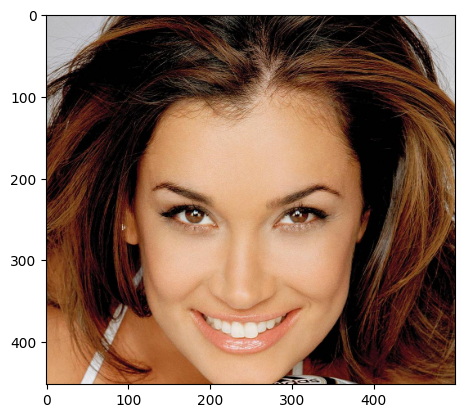

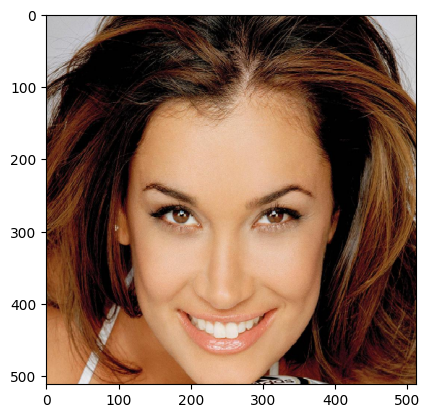

torch.Size([3, 64, 64])
(17, 64, 64)
(17, 64, 64) 17


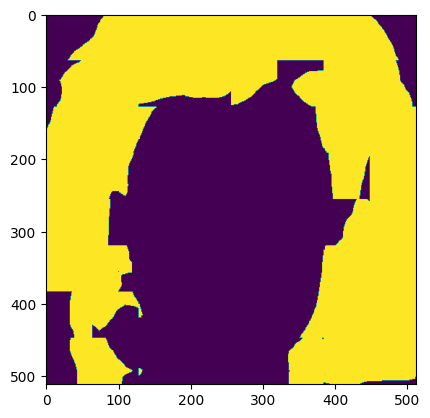

In [6]:
combined_gen_masks = evaluate(img_dir=img_dir, mask_dir=mask_dir, output_dir=output_dir, checkpoint_pth='/home/ishan/projects/patch_seg/VLR_Project/VLR/Bisenetv1_for_github/res/terminal_test/bisenet_celeb_a_3/14.pth')

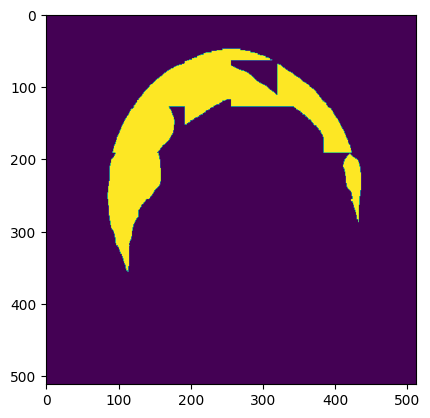

In [7]:
plt.imshow(combined_gen_masks[0])

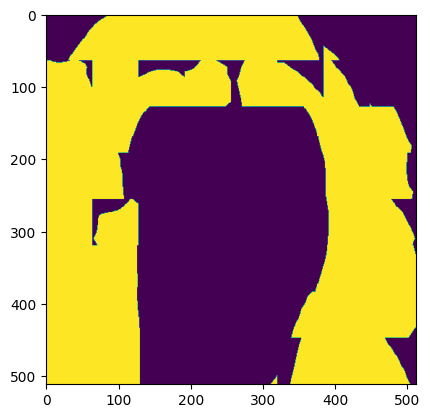

In [26]:
plt.imshow(combined_gen_masks[0])

In [7]:
to_tensor = transforms.Compose([
        transforms.ToTensor(),
        ])

In [8]:
idx = 0
img = mpimg.imread(img_file_paths[idx])
mask = cv2.imread(mask_file_paths[idx], cv2.IMREAD_GRAYSCALE)

hair_mask = create_hair_mask(mask, hair_label=8)
x1, x2, y1, y2 = get_crop_coords(hair_mask)
cropped_mask = hair_mask[y1:y2, x1:x2]
cropped_img = img.copy()[y1:y2, x1:x2]
img_patches, patches, _,  patch_map_linear = get_patches_inference(cropped_img, cropped_mask, threshold=0.9)


In [ ]:
mask = cv2.imread(mask_file_paths[idx])

In [ ]:
mask.shape

(512, 512, 3)

0


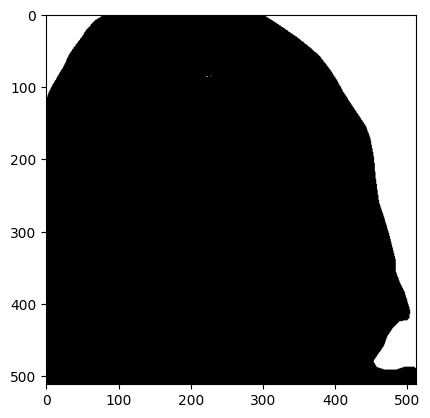

1


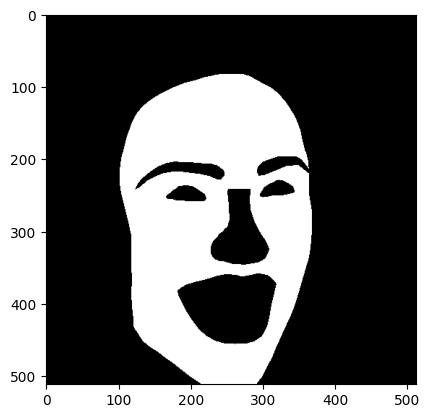

2


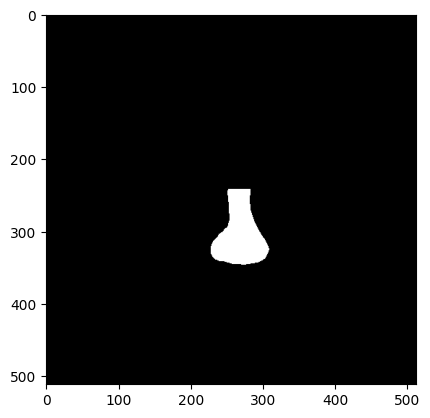

3


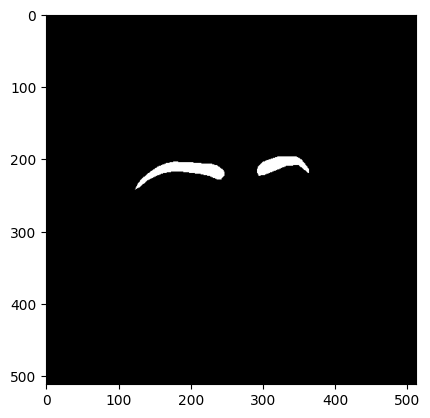

4


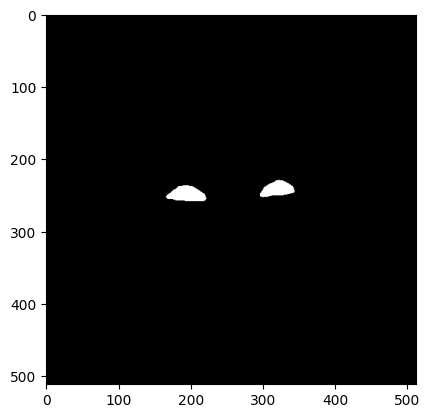

5


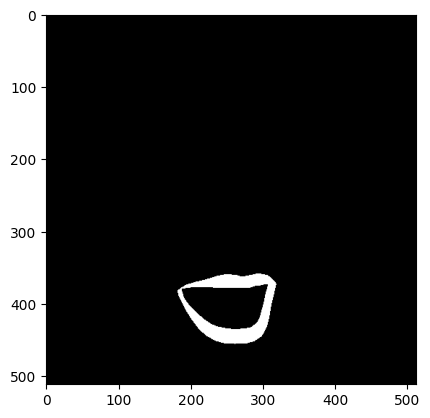

6


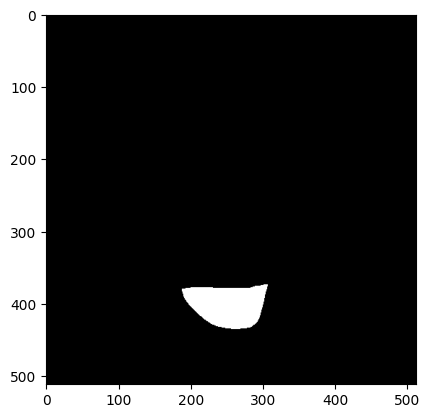

8


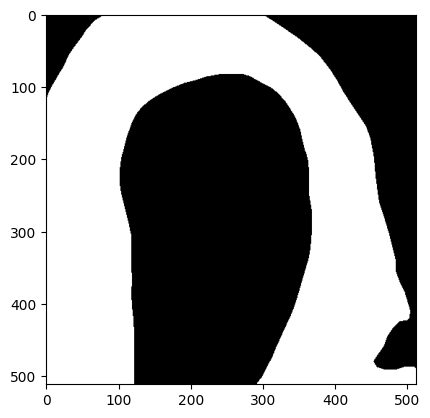

12


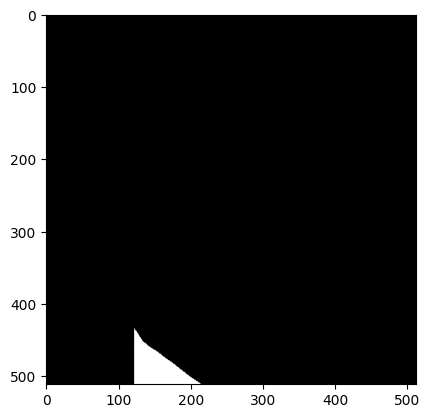

In [ ]:
for i in np.unique(mask):
    image_array_test = mask.copy()
    image_array_test_mono = np.where(image_array_test == i,1,0)
    plt.imshow(image_array_test_mono*255)
    print(i)
    plt.show()
    

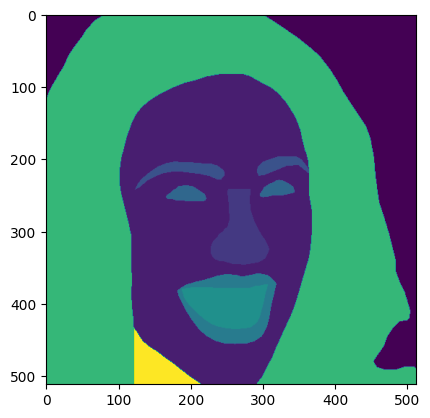

In [ ]:
plt.imshow(mask)

In [ ]:
data_dict = dict(
    original_image_size = img.shape,
    seg_mask_size = mask.shape,
    cropped_mask_size = cropped_mask.shape,
    patch_map_linear = patch_map_linear,
    patch_coords = [x1, x2, y1, y2],
    patch_coords_format = 'x1, x2, y1, y2',
)
